In [60]:
import logging
import os
import time
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import wraps

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from scipy.spatial import KDTree
from shapely.geometry import Polygon as Poly
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle

In [61]:
# Setup logging system with timing capabilities
class TimingLogger:
    def __init__(self, name="SymbolDetectionPipeline", level=logging.INFO):
        self.logger = logging.getLogger(name)
        self.logger.setLevel(level)
        
        # Clear existing handlers
        for handler in self.logger.handlers[:]:
            self.logger.removeHandler(handler)
        
        # Create formatter with timing info
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - [%(funcName)s] - %(message)s',
            datefmt='%H:%M:%S'
        )
        
        # Console handler
        console_handler = logging.StreamHandler()
        console_handler.setFormatter(formatter)
        self.logger.addHandler(console_handler)
        
        # Stack to track nested timing operations
        self._timing_stack = []
        
    def info(self, message):
        self.logger.info(message)
        
    def debug(self, message):
        self.logger.debug(message)
        
    def warning(self, message):
        self.logger.warning(message)
        
    def error(self, message):
        self.logger.error(message)
    
    @contextmanager
    def timer(self, operation_name, log_level=logging.INFO):
        """Context manager for timing operations with nested support"""
        indent = "  " * len(self._timing_stack)
        start_time = time.time()
        
        self.logger.log(log_level, f"{indent}▶ Starting: {operation_name}")
        self._timing_stack.append(operation_name)
        
        try:
            yield
        finally:
            end_time = time.time()
            elapsed = end_time - start_time
            self._timing_stack.pop()
            
            if elapsed < 1:
                time_str = f"{elapsed*1000:.1f}ms"
            else:
                time_str = f"{elapsed:.2f}s"
                
            self.logger.log(log_level, f"{indent}✓ Completed: {operation_name} ({time_str})")
    
    def time_function(self, func_name=None, log_level=logging.INFO):
        """Decorator for timing functions"""
        def decorator(func):
            @wraps(func)
            def wrapper(*args, **kwargs):
                operation_name = func_name or f"{func.__name__}"
                with self.timer(operation_name, log_level):
                    return func(*args, **kwargs)
            return wrapper
        return decorator

# Global logger instance
logger = TimingLogger("SymbolDetectionPipeline", level=logging.DEBUG)


In [62]:
# Logging utilities and configuration
def set_logging_level(level):
    """
    Set the logging level for the pipeline.
    
    Args:
        level: logging.DEBUG, logging.INFO, logging.WARNING, logging.ERROR
               or string: 'DEBUG', 'INFO', 'WARNING', 'ERROR'
    """
    if isinstance(level, str):
        level = getattr(logging, level.upper())
    
    logger.logger.setLevel(level)
    logger.info(f"Logging level set to: {logging.getLevelName(level)}")

def enable_debug_logging():
    """Enable detailed debug logging for all operations"""
    set_logging_level(logging.DEBUG)
    logger.info("🔍 Debug mode enabled - detailed timing for all operations")

def enable_standard_logging():
    """Enable standard logging (default level)"""
    set_logging_level(logging.INFO)
    logger.info("📝 Standard logging enabled")

def enable_quiet_logging():
    """Enable minimal logging (warnings and errors only)"""
    set_logging_level(logging.WARNING)
    print("⚠️  Quiet mode enabled - warnings and errors only")

# Set default level
logger.info("✅ Logging system initialized")
logger.info("Available logging controls:")
logger.info("  - enable_debug_logging(): Detailed timing for all operations")
logger.info("  - enable_standard_logging(): Normal pipeline progress (default)")
logger.info("  - enable_quiet_logging(): Warnings and errors only")
logger.info("  - set_logging_level(level): Custom level (DEBUG/INFO/WARNING/ERROR)")


12:25:21 - SymbolDetectionPipeline - INFO - [info] - ✅ Logging system initialized
12:25:21 - SymbolDetectionPipeline - INFO - [info] - Available logging controls:
12:25:21 - SymbolDetectionPipeline - INFO - [info] -   - enable_debug_logging(): Detailed timing for all operations
12:25:21 - SymbolDetectionPipeline - INFO - [info] -   - enable_standard_logging(): Normal pipeline progress (default)
12:25:21 - SymbolDetectionPipeline - INFO - [info] -   - enable_quiet_logging(): Warnings and errors only
12:25:21 - SymbolDetectionPipeline - INFO - [info] -   - set_logging_level(level): Custom level (DEBUG/INFO/WARNING/ERROR)


# Preprocessing templates

- Get the template colors to be used for matching
- Load the actual template images
- Adjust edges to accomodate rotated templates
- Assign colors to each template

12:25:21 - SymbolDetectionPipeline - INFO - [timer] - ▶ Starting: Template color extraction from /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/templates
12:25:21 - SymbolDetectionPipeline - INFO - [info] - Extracting colors from templates with prefix: GHS, min_percentage: 0.1
12:25:21 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Directory scanning
12:25:21 - SymbolDetectionPipeline - INFO - [info] - Found 24 PNG files to process
12:25:21 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: Directory scanning (7.6ms)
12:25:21 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Processing 24 template images
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -     ▶ Starting: Processing GHS_00004.png
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -       ▶ Starting: Image loading and conversion
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -       ✓ Completed: Image loading and conversion (3.7ms)


12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -       ▶ Starting: Color frequency analysis
12:25:21 - SymbolDetectionPipeline - DEBUG - [debug] - Analyzing 22500 pixels with threshold 2250
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -       ✓ Completed: Color frequency analysis (53.6ms)
12:25:21 - SymbolDetectionPipeline - DEBUG - [debug] - Found significant color: [231, 120, 23] (count: 9050, 40.2%)
12:25:21 - SymbolDetectionPipeline - DEBUG - [debug] - Extracted 1 new colors from GHS_00004.png
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -     ✓ Completed: Processing GHS_00004.png (61.6ms)
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -     ▶ Starting: Processing GHS_00010.png
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -       ▶ Starting: Image loading and conversion
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -       ✓ Completed: Image loading and conversion (2.5ms)
12:25:21 - SymbolDetectionPipeline - DEBUG - [timer] -       ▶ Start

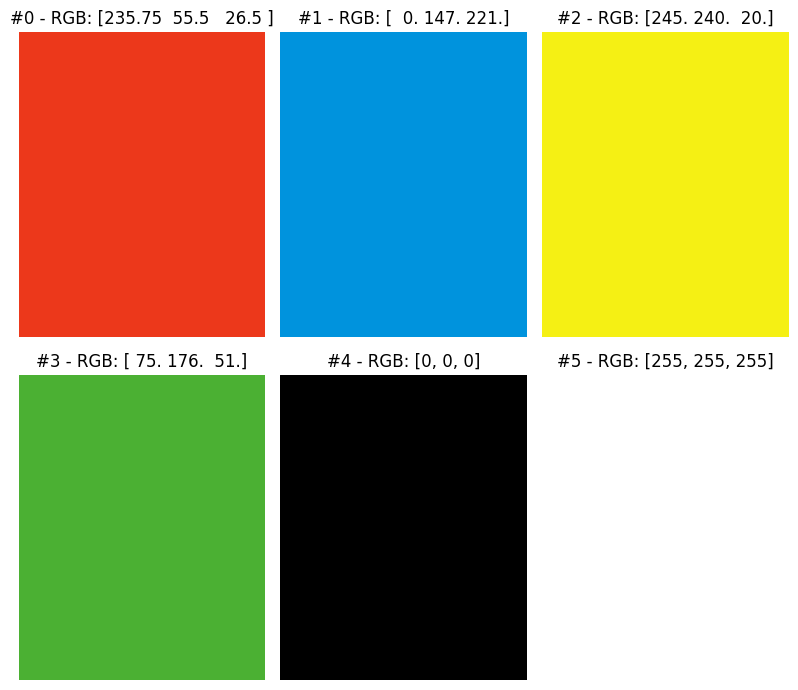

12:25:22 - SymbolDetectionPipeline - DEBUG - [timer] - ▶ Starting: Loading template: GHS_00000.png
12:25:22 - SymbolDetectionPipeline - DEBUG - [debug] - Template loaded: 150x150 pixels
12:25:22 - SymbolDetectionPipeline - DEBUG - [timer] - ✓ Completed: Loading template: GHS_00000.png (6.2ms)


{'image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 'corners': array([[  0.,   0.],
       [149.,   0.],
       [149., 149.],
       [  0., 149.]], dtype=float32), 'shape': (150, 150), 'path': '/Users/frbuccoliero/Desktop/Thesis/Tests/templa

In [63]:
def get_template_colors(templates_path, min_pixel_percentage=0.1, filename_prefix=None, skip_black_white=True, clustering_eps=1):
    with logger.timer(f"Template color extraction from {templates_path}"):
        logger.info(f"Extracting colors from templates with prefix: {filename_prefix}, min_percentage: {min_pixel_percentage}")
        
        # Get all PNG files from the path
        with logger.timer("Directory scanning"):
            png_files = [f for f in os.listdir(templates_path) if f.lower().endswith('.png')]
            if filename_prefix:
                png_files = [f for f in png_files if f.startswith(filename_prefix)]
            logger.info(f"Found {len(png_files)} PNG files to process")

        # Global list to store all valid colors
        all_valid_colors = []
        processed_files = 0

        # Process each PNG image
        with logger.timer(f"Processing {len(png_files)} template images"):
            for png_file in png_files:
                with logger.timer(f"Processing {png_file}", log_level=logging.DEBUG):
                    img_path = os.path.join(templates_path, png_file)
                    with logger.timer("Image loading and conversion", log_level=logging.DEBUG):
                        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                        if img is None:
                            raise ValueError(f"Could not load image: {img_path}")
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        pixel_colors = img.reshape(-1, 3)
                    
                    # Color analysis
                    with logger.timer("Color frequency analysis", log_level=logging.DEBUG):
                        color_counts = Counter(map(tuple, pixel_colors))
                        total_pixels = len(pixel_colors)
                        threshold = total_pixels * min_pixel_percentage
                        logger.debug(f"Analyzing {total_pixels} pixels with threshold {threshold:.0f}")
                    
                    # Extract significant colors
                    colors_found_in_image = 0
                    for color, count in color_counts.items():
                        if count >= threshold:
                            color_list = list(color)
                            if color_list not in all_valid_colors:
                                if skip_black_white and (np.all(np.array(color_list) == 0) or np.all(np.array(color_list) == 255)):
                                    continue
                                all_valid_colors.append(color_list)
                                colors_found_in_image += 1
                                logger.debug(f"Found significant color: {color_list} (count: {count}, {count/total_pixels*100:.1f}%)")
                    
                    if colors_found_in_image > 0:
                        logger.debug(f"Extracted {colors_found_in_image} new colors from {png_file}")
                    
                processed_files += 1

        logger.info(f"Color extraction complete: {len(all_valid_colors)} unique colors from {processed_files} images")
        logger.info(f"Extracted colors: {all_valid_colors}")

        # Cluster colors using DBSCAN
        color_clusters = {}
        with logger.timer("Clustering colors using DBSCAN"):
            colors_array = np.array(all_valid_colors)
            scaler = StandardScaler()
            colors_scaled = scaler.fit_transform(colors_array)
            dbscan = DBSCAN(eps=clustering_eps, min_samples=1)
            clusters = dbscan.fit_predict(colors_scaled)
            for color, cluster in zip(all_valid_colors, clusters):
              if cluster not in color_clusters:
                color_clusters[cluster] = []
              color_clusters[cluster].append(color)
        
        logger.info(f"Clustered {len(all_valid_colors)} colors into {len(color_clusters)} clusters")

        # the list to return is now the list of average colors for each cluster
        toReturn = [np.mean(color_clusters[cluster], axis=0) for cluster in color_clusters]
        return toReturn, color_clusters

def plot_colors(colors, cols=3):
	n = len(colors)
	rows = (n + cols - 1) // cols  # Calculate number of rows needed
	fig, axes = plt.subplots(rows, cols, figsize=(cols+5, rows+5), subplot_kw=dict(xticks=[], yticks=[]))

	# Flatten axes for easy indexing, whether it's 1D or 2D
	if rows == 1 or cols == 1:
		axes = np.array(axes).reshape(-1)
	else:
		axes = axes.flatten()

	# Plot each color
	for i, color in enumerate(colors):
		axes[i].add_patch(Rectangle((0, 0), 1, 1, color=np.array(color)/255))
		axes[i].set_xticks([])
		axes[i].set_yticks([])
		axes[i].set_xlim(0, 1)
		axes[i].set_ylim(0, 1)
		axes[i].axis('off')
		axes[i].set_title(f"#{i} - RGB: {color}")

	# Hide any unused subplots
	for j in range(len(colors), rows * cols):
		axes[j].axis('off')

	plt.tight_layout()
	plt.show()


def load_template_info(template_path, clusters, rotated=False):
    """
    Load template and extract corner points for homography matching.
    Adjusts corners when template is rotated 45 degrees clockwise.
    """
    with logger.timer(f"Loading template: {os.path.basename(template_path)}", log_level=logging.DEBUG):
        template = cv2.imread(template_path, cv2.IMREAD_COLOR)
        template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
        if template is None:
            raise ValueError(f"Could not load template: {template_path}")
        
        # Define template corners (clockwise from top-left)
        h, w = template.shape[:2]
        
        if not rotated:
          template_corners = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32)
        else:
          assert w == h, "Rotated template must be square"
          template_corners = np.array([[h//2, h//2], [h, h//2], [h//2, h], [0, h//2]], dtype=np.float32)

        # temporarly add black and white to the reference colors as single item clusters
        clusters_temp = clusters.copy()
        clusters_temp[len(clusters_temp)] = [[0, 0, 0]]
        clusters_temp[len(clusters_temp)] = [[255, 255, 255]]
        
        colors = []

        # Check if template contains any of the reference colors. If so, add the index of the color to colors.
        # Search inside each cluster for exact matches, not the average color
        template_reshaped = template.reshape(-1, 3)
        for cluster_idx, cluster in clusters_temp.items():
          for color in cluster:
              # Find if any pixel matches this color exactly
              if np.any(np.all(template_reshaped == color, axis=1)):
                  colors.append(cluster_idx)
                  break
        
        if len(colors) == 0:
          logger.warning(f"No known color found in template {template_path}")
                  
        logger.debug(f"Template loaded: {w}x{h} pixels")
        
        return {
            'image': template,
            'corners': template_corners,
            'shape': (h, w),
            'path': template_path,
            'colors': colors
        }

_colors, _clusters = get_template_colors("/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/templates", filename_prefix="GHS")
# temp for viz, add black and white
_colors_temp = _colors.copy()
_colors_temp.append([0, 0, 0])
_colors_temp.append([255, 255, 255])
plot_colors(_colors_temp, cols=3)
del _colors_temp

_template_info = load_template_info("/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/templates/GHS_00000.png", _clusters)
print(_template_info)

# Color + Lines Based Symbol Detection Pipeline

- **Color Splitting (Steps 1-2)**: RGB color segmentation algorithms to create binary masks from reference colors
- **Line-based ROI Detection (Step 3)**: Line detection and closed path finding using KDTree adjacency
- **Common Rectangle Detection (Step 4)**: IoU-based matching of quadrilaterals across color masks
- **Template Matching (Step 5)**: Homography-based verification with photometric check

## Step 1-2: Color Splitting Utility


In [64]:
def get_rgb_masks(full_img, reference_RGB, 
    threshold=0.1, 
    black_val_threshold=50, 
    white_sat_threshold=0.2, white_val_threshold=180):

    '''
    Combines RGB nearest color for chromatic masks + explicit cuts for black/white.

    Args:
        full_img: RGB image uint8 (H,W,3)
        reference_RGB: list of RGB colors
        threshold: fraction of max RGB distance (0-1)
        black_val_threshold: max intensity for black (0-255)
        white_sat_threshold: max (std dev / mean) across RGB for white
        white_val_threshold: min intensity for white (0-255)

    Returns:
        list of masks for each reference color + black mask + white mask
    '''
    with logger.timer("RGB color mask generation"):
        h, w, _ = full_img.shape
        total_pixels = h * w
        logger.info(f"Generating RGB masks for {len(reference_RGB)} colors on {h}x{w} image ({total_pixels:,} pixels)")
        logger.debug(f"Parameters: threshold={threshold}, black_val={black_val_threshold}, white_sat={white_sat_threshold}, white_val={white_val_threshold}")
        
        with logger.timer("Image preprocessing"):
            pixels = full_img.reshape(-1, 3).astype(np.float32)
            logger.debug(f"Reshaped image to {pixels.shape}")

        # 1. Black mask generation
        with logger.timer("Black mask computation"):
            pixel_vals = np.mean(pixels, axis=1)
            black_mask_flat = (pixel_vals < black_val_threshold)
            black_pixel_count = np.sum(black_mask_flat)
            logger.debug(f"Black mask: {black_pixel_count:,} pixels ({black_pixel_count/total_pixels*100:.1f}%)")

        # 2. White mask generation
        with logger.timer("White mask computation"):
            pixel_std = np.std(pixels, axis=1)
            white_mask_flat = (pixel_std / (pixel_vals + 1e-5) < white_sat_threshold) & \
                              (pixel_vals > white_val_threshold)
            white_pixel_count = np.sum(white_mask_flat)
            logger.debug(f"White mask: {white_pixel_count:,} pixels ({white_pixel_count/total_pixels*100:.1f}%)")

        # 3. Color distance computation
        with logger.timer("Color distance computation"):
            C = np.array(reference_RGB, dtype=np.float32)
            logger.debug(f"Reference colors: {C.shape[0]} colors")
            
            pixels_norm2 = np.sum(pixels**2, axis=1, keepdims=True)
            C_norm2 = np.sum(C**2, axis=1)
            dots = pixels @ C.T
            dists2 = pixels_norm2 - 2*dots + C_norm2

            # Invalidate black & white zones
            excluded_pixels = black_mask_flat | white_mask_flat
            dists2[excluded_pixels, :] = np.inf
            excluded_count = np.sum(excluded_pixels)
            logger.debug(f"Excluded {excluded_count:,} black/white pixels from color matching")

            nearest_idx = np.argmin(dists2, axis=1)
            min_dists2 = np.min(dists2, axis=1)
            abs_thresh2 = (threshold * 441.67295593)**2

        # 4. Build color masks
        with logger.timer("Color mask assembly"):
            results_masks = []
            for i in range(len(reference_RGB)):
                mask_flat = (nearest_idx == i) & (min_dists2 < abs_thresh2)
                mask_img = (mask_flat.reshape(h,w).astype(np.uint8)) * 255
                results_masks.append(mask_img)
                
                color_pixel_count = np.sum(mask_flat)
                logger.debug(f"Color {i} {reference_RGB[i]}: {color_pixel_count:,} pixels ({color_pixel_count/total_pixels*100:.1f}%)")

        # 5. Add black + white masks
        with logger.timer("Monochrome mask finalization"):
            black_img = black_mask_flat.reshape(h,w).astype(np.uint8) * 255
            white_img = white_mask_flat.reshape(h,w).astype(np.uint8) * 255
            results_masks.append(black_img)
            results_masks.append(white_img)

        logger.info(f"Generated {len(results_masks)} total masks ({len(reference_RGB)} color + 2 monochrome)")
        return results_masks
        

12:25:23 - SymbolDetectionPipeline - INFO - [timer] - ▶ Starting: RGB color mask generation
12:25:23 - SymbolDetectionPipeline - INFO - [info] - Generating RGB masks for 4 colors on 4032x3024 image (12,192,768 pixels)
12:25:23 - SymbolDetectionPipeline - DEBUG - [debug] - Parameters: threshold=0.1, black_val=50, white_sat=0.2, white_val=180
12:25:23 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Image preprocessing
12:25:23 - SymbolDetectionPipeline - DEBUG - [debug] - Reshaped image to (12192768, 3)
12:25:23 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: Image preprocessing (159.9ms)
12:25:23 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Black mask computation
12:25:23 - SymbolDetectionPipeline - DEBUG - [debug] - Black mask: 2,064,131 pixels (16.9%)
12:25:23 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: Black mask computation (223.8ms)
12:25:23 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: White mask computation
12:25:2

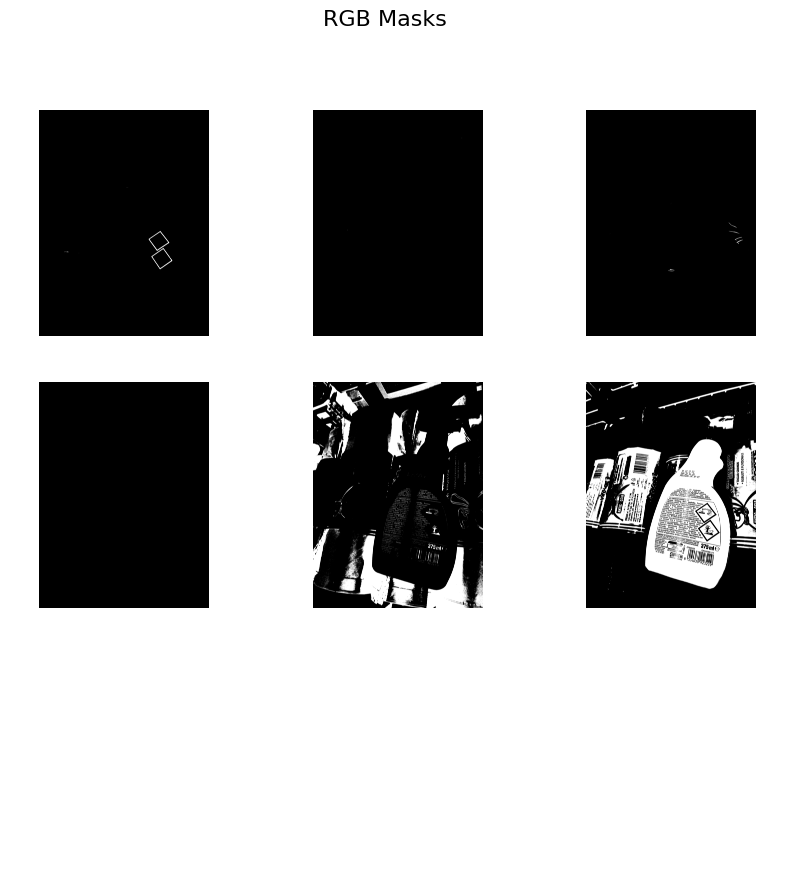

In [65]:
_image_path = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00000.jpg"
_image = cv2.imread(_image_path, cv2.IMREAD_COLOR)
_image = cv2.cvtColor(_image, cv2.COLOR_BGR2RGB)

_masks = get_rgb_masks(_image, _colors)

# Visualize the masks in a grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for ax in axs.flat:
    ax.axis('off')

for i, mask in enumerate(_masks):
    axs[i//3, i%3].imshow(mask, cmap='gray')

#add title to the figure
fig.suptitle('RGB Masks', fontsize=16)

plt.show()

## Step 3: Line-based ROI Detection

This is the core of the approach - sophisticated line detection and closed path finding using:
- LSD (Line Segment Detector) for robust line detection
- KDTree for efficient spatial queries
- Adjacency-based 4-line cycle detection
- Geometric validation of quadrilaterals


In [75]:
def line_intersection(line1, line2):
	"""
	Finds the intersection of two lines. Each line is defined by two points.
	Returns the intersection point (x, y) or None if lines are parallel.
	"""
	(x1, y1), (x2, y2) = line1
	(x3, y3), (x4, y4) = line2

	den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
	if abs(den) < 1e-6:  # Use a small tolerance for floating point comparison
		return None  # Lines are parallel or collinear

	t_num = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)
	t = t_num / den
	
	intersect_x = x1 + t * (x2 - x1)
	intersect_y = y1 + t * (y2 - y1)
	
	return (intersect_x, intersect_y)

def get_internal_angle(p1, p2, p3):
	"""Calculates the internal angle at vertex p2, formed by p1-p2-p3."""
	v1 = np.subtract(p1, p2)
	v2 = np.subtract(p3, p2)

	# suppress warning for division by zero in case of zero-length vectors
	if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
		return 0.0
	
	cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
	
	# Clip for numerical stability and convert to degrees
	angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
	return angle

def euclidean_dist(p1, p2):
		return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

def is_reasonable_quad(ordered_points, min_angle=60, max_angle=120, min_width_height_ratio=0.5, max_width_height_ratio=2):
	"""
	Checks if a quadrilateral, defined by ordered points, has reasonable
	internal angles. Also checks if the quadrilateral is convex, and has a reasonable width/height ratio.
	"""
	angles = []
	num_points = len(ordered_points)
	if num_points != 4: 
		return False

	# Check convexity using cross products (all z-components should have the same sign)
	def cross_z(a, b, c):
		ab = np.subtract(b, a)
		bc = np.subtract(c, b)
		return ab[0]*bc[1] - ab[1]*bc[0]

	cross_signs = []
	for i in range(num_points):
		p0 = ordered_points[i]
		p1 = ordered_points[(i + 1) % num_points]
		p2 = ordered_points[(i + 2) % num_points]
		cross = cross_z(p0, p1, p2)
		cross_signs.append(np.sign(cross))
	# All cross products should have the same sign (convex)
	if not (all(s > 0 for s in cross_signs) or all(s < 0 for s in cross_signs)):
		return False

	# Compute angles
	for i in range(num_points):
		p_prev = ordered_points[(i - 1 + num_points) % num_points]
		p_curr = ordered_points[i]
		p_next = ordered_points[(i + 1) % num_points]
		angle = get_internal_angle(p_prev, p_curr, p_next)
		angles.append(angle)
	if not all(min_angle <= a <= max_angle for a in angles):
		return False

	# Check width/height ratio
	side1 = euclidean_dist(ordered_points[0], ordered_points[1])
	side2 = euclidean_dist(ordered_points[1], ordered_points[2])
	side3 = euclidean_dist(ordered_points[2], ordered_points[3])
	side4 = euclidean_dist(ordered_points[3], ordered_points[0])

	# Assume opposite sides should be roughly equal, average them
	width = (side1 + side3) / 2
	height = (side2 + side4) / 2

	if height == 0:
			return False
	ratio = width / height
	if not (min_width_height_ratio <= ratio <= max_width_height_ratio):
			return False

	return True

def find_loops(segments, adjacency_radius=None):
		"""
		Greedily searches for 4-line cycles, returning them as ordered paths.
		adjacency_radius: if None, adaptively set to 10% of mean segment length (min 5px).
		angle_prune_range: tuple (min_angle, max_angle) for early pruning between consecutive lines.
		"""
		with logger.timer("4-line cycle detection"):
				if not segments:
						logger.warning("No segments provided for loop detection")
						return []
				
				logger.info(f"Searching for 4-line cycles in {len(segments)} segments")
				
				# Compute adaptive radius if not provided
				with logger.timer("Adjacency radius computation"):
						if adjacency_radius is None:
								seg_lengths = [np.linalg.norm(np.subtract(seg[0], seg[1])) for seg in segments]
								mean_length = np.mean(seg_lengths) if seg_lengths else 10
								adjacency_radius = max(5, 0.05 * mean_length)
								logger.debug(f"Computed adaptive adjacency radius: {adjacency_radius:.1f} (mean segment length: {mean_length:.1f})")
						else:
								logger.debug(f"Using provided adjacency radius: {adjacency_radius}")
				
				# Build spatial index
				with logger.timer("KDTree construction"):
						points = [pt for seg in segments for pt in seg]
						kdtree = KDTree(points)
						logger.debug(f"Built KDTree for {len(points)} points")
				
				# Build adjacency graph
				with logger.timer("Adjacency graph construction"):
						adjacency = defaultdict(set)
						total_connections = 0
						
						for i, segment in enumerate(segments):
							p1, p2 = segment
							for point in [p1, p2]:
								proximal_point_indices = kdtree.query_ball_point(np.array(point).reshape(1, -1), r=adjacency_radius)[0]
								for j in proximal_point_indices:
										other_line_idx = j // 2
										if other_line_idx != i:
												adjacency[i].add(other_line_idx)
												total_connections += 1
						
						logger.debug(f"Built adjacency graph with {len(adjacency)} nodes and {total_connections} connections")
				
				# Find 4-line cycles
				with logger.timer("Cycle enumeration"):
						loops = []
						seen_loops = set()
						cycles_explored = 0
						
						for a in adjacency:
								for b in adjacency[a]:
										for c in adjacency[b]:
												if c == a:
														continue
												if a in adjacency[c]:
														continue
												for d in adjacency[c]:
														cycles_explored += 1
														if d == a or d == b:
																continue
														if a in adjacency[d]:
																loop = (a, b, c, d)
																canonical_loop = frozenset(loop)
																if canonical_loop not in seen_loops:
																		loops.append(loop)
																		seen_loops.add(canonical_loop)
						
						logger.debug(f"Explored {cycles_explored} potential cycles")
						logger.info(f"Found {len(loops)} unique 4-line cycles")
				
				return loops

def quad_distance(q1, q2):
		"""Sum of Manhattan distances between corresponding vertices."""
		return sum(abs(a[0] - b[0]) + abs(a[1] - b[1]) for a, b in zip(q1, q2))

def prune_quadrilaterals(quads, dedup_thresh=10):
		"""
		Prune and deduplicate quadrilaterals.
		- Remove quads fully contained in others.
		- Replace smaller with larger ones.
		- Deduplicate near-identical ones based on vertex distance.
		"""
		processed = []
		processed_pts = []

		for new_quad_pts in quads:
				new_poly = Poly(new_quad_pts).convex_hull
				keep_new = True
				to_remove = []

				for i, existing_poly in enumerate(processed):
						if existing_poly.covers(new_poly):
								keep_new = False
								break
						elif new_poly.covers(existing_poly):
								to_remove.append(i)

				for idx in reversed(to_remove):
						del processed[idx]
						del processed_pts[idx]

				if keep_new:
						processed.append(new_poly)
						processed_pts.append(new_quad_pts)

		# Post-process deduplication: remove near-identical quadrilaterals
		final_quads = []
		seen = []

		for i, quad in enumerate(processed_pts):
				is_duplicate = False
				for seen_quad in seen:
						if quad_distance(quad, seen_quad) < dedup_thresh:
								is_duplicate = True
								break
				if not is_duplicate:
						final_quads.append(processed[i])
						seen.append(quad)

		return [list(poly.exterior.coords)[:-1] for poly in final_quads]

def get_quadrilaterals_from_loops(loops, segments, debug=False):
	"""
	Processes ordered loops to create a binary mask of valid quadrilaterals.
	"""

	quads = []
	
	for loop_indices in loops:  # e.g., (a, b, c, d)
		lines = [segments[i] for i in loop_indices]
		
		# 1. Find the 4 intersection points (vertices) from the ordered path
		v1 = line_intersection(lines[0], lines[1]) # Intersection of a & b
		v2 = line_intersection(lines[1], lines[2]) # Intersection of b & c
		v3 = line_intersection(lines[2], lines[3]) # Intersection of c & d
		v4 = line_intersection(lines[3], lines[0]) # Intersection of d & a
		
		vertices = [v for v in [v1, v2, v3, v4] if v is not None]
		
		# We need exactly 4 vertices to form a quadrilateral
		if len(vertices) != 4:
			continue
			
		# The vertices are already ordered by path traversal.
		ordered_vertices = np.array(vertices, dtype=np.int32)

		# 2. Validate the quad's shape using its internal angles
		if is_reasonable_quad(ordered_vertices):
			quads.append(ordered_vertices)
	
	logger.info(f"Found {len(quads)} quads")
	quads = prune_quadrilaterals(quads)
	logger.info(f"Quads after pruning: {len(quads)}")


	# debug: Plot all quads with random colors and their vertices
	if debug:
		# debug: print coord for each quad
		for quad in quads:
			print(quad)
		plt.figure(figsize=(12, 12))
		plt.imshow(mask, cmap='gray', alpha=0.2)
		plt.title("Detected Quadrilaterals (Vertices Colored)")

		for quad in quads:
			# Ensure quad is a numpy array of shape (4, 2) and dtype int32
			quad_pts = np.array(quad, dtype=np.int32)
			quad_pts = quad_pts.reshape((-1, 1, 2))  # shape (4, 1, 2) as required by fillPoly
			cv2.fillPoly(mask, [quad_pts], (255,))

			# For plotting: get (x, y) coordinates
			quad_xy = quad_pts.reshape(-1, 2)
			color = np.random.rand(3)
			plt.plot(
				np.append(quad_xy[:, 0], quad_xy[0, 0]),
				np.append(quad_xy[:, 1], quad_xy[0, 1]),
				color=color, linewidth=2, marker='o', markersize=8, markerfacecolor=color
			)
			# Optionally, plot the vertex indices
			for idx, (x, y) in enumerate(quad_xy):
				plt.text(x, y, str(idx), color=color, fontsize=12, fontweight='bold')

			plt.axis('equal')
			plt.gca().invert_yaxis()
			plt.show()
	
	return quads

def get_segments(image, min_line_length_percent=0.05):
		min_line_length = min(image.shape[0], image.shape[1]) * min_line_length_percent
		with logger.timer("Line segment detection"):
				logger.debug(f"Detecting line segments in {image.shape} image")
				
				# LSD Line Segment Detector
				with logger.timer("LSD detector initialization"):
						lsd = cv2.line_descriptor.LSDDetector.createLSDDetector()
				
				with logger.timer("LSD line detection"):
						keylines_raw = lsd.detect(image, scale=2, numOctaves=4)
						raw_count = len(keylines_raw) if keylines_raw else 0
						logger.debug(f"LSD detected {raw_count} raw line segments")

				if keylines_raw is None or len(keylines_raw) < 4:
						logger.warning(f"Insufficient line segments detected: {raw_count} (minimum: 4)")
						return []

				# Filter by minimum length
				with logger.timer("Line segment filtering"):
						segments = []

						for line in keylines_raw:
								p1 = np.array([line.startPointX, line.startPointY])
								p2 = np.array([line.endPointX, line.endPointY])
								length = np.linalg.norm(p1 - p2)
								
								if length > min_line_length:
										segments.append(((p1[0], p1[1]), (p2[0], p2[1])))
						
						logger.info(f"Filtered to {len(segments)} segments (min_length: {min_line_length})")
		
		return segments

def merge_collinear_segments(segments, angle_tolerance=5, distance_tolerance=5):
		"""
		Merges nearly collinear and close line segments using an iterative, proximity-aware approach.

		Args:
				segments: A list of line segments, e.g., [((x1, y1), (x2, y2)), ...].
				angle_tolerance: Max angle difference (degrees) to be considered collinear.
				distance_tolerance: Max distance between endpoints to be considered for merging.

		Returns:
				A new list of merged line segments.
		"""
		if not segments:
				return []

		def get_line_angle(line):
				"""Calculates the angle of a line segment in degrees."""
				(x1, y1), (x2, y2) = line
				angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
				return angle if angle >= 0 else angle + 180

		def are_segments_close(seg1, seg2, distance_tolerance):
				"""Checks if any endpoint of seg1 is close to any endpoint of seg2."""
				for p1 in seg1:
						for p2 in seg2:
								if np.linalg.norm(np.subtract(p1, p2)) < distance_tolerance:
										return True
				return False

		segments_pool = segments.copy()
		merged_lines = []

		while segments_pool:
				# Start a new group with the first segment from the pool
				seed = segments_pool.pop(0)
				current_group = [seed]
				
				# Iteratively find segments to add to the current group
				while True:
						found_new_segment = False
						for i in range(len(segments_pool) - 1, -1, -1):
								candidate = segments_pool[i]
								
								# Check for collinearity and proximity
								is_collinear = abs(get_line_angle(seed) - get_line_angle(candidate)) < angle_tolerance
								is_close = any(are_segments_close(member, candidate, distance_tolerance) for member in current_group)

								if is_collinear and is_close:
										current_group.append(candidate)
										segments_pool.pop(i)
										found_new_segment = True
						
						if not found_new_segment:
								break
				
				# Merge the current group into one line segment using PCA
				points = [pt for seg in current_group for pt in seg]
				points_np = np.array(points, dtype=np.float32)
				mean = np.mean(points_np, axis=0)
				_, _, vt = np.linalg.svd(points_np - mean)
				direction = vt[0]

				# Project all points onto the principal axis
				projections = np.dot(points_np - mean, direction)
				min_proj, max_proj = projections.min(), projections.max()

				# Compute the two endpoints of the merged segment
				pt1 = mean + direction * min_proj
				pt2 = mean + direction * max_proj

				merged_lines.append((tuple(pt1), tuple(pt2)))

		return merged_lines


12:31:58 - SymbolDetectionPipeline - INFO - [timer] - ▶ Starting: Line segment detection
12:31:58 - SymbolDetectionPipeline - DEBUG - [debug] - Detecting line segments in (4032, 3024) image
12:31:58 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: LSD detector initialization
12:31:58 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: LSD detector initialization (0.8ms)
12:31:58 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: LSD line detection


12:31:59 - SymbolDetectionPipeline - DEBUG - [debug] - LSD detected 183 raw line segments
12:31:59 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: LSD line detection (1.42s)
12:31:59 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Line segment filtering
12:31:59 - SymbolDetectionPipeline - INFO - [info] - Filtered to 48 segments (min_length: 151.20000000000002)
12:31:59 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: Line segment filtering (3.2ms)
12:31:59 - SymbolDetectionPipeline - INFO - [timer] - ✓ Completed: Line segment detection (1.43s)


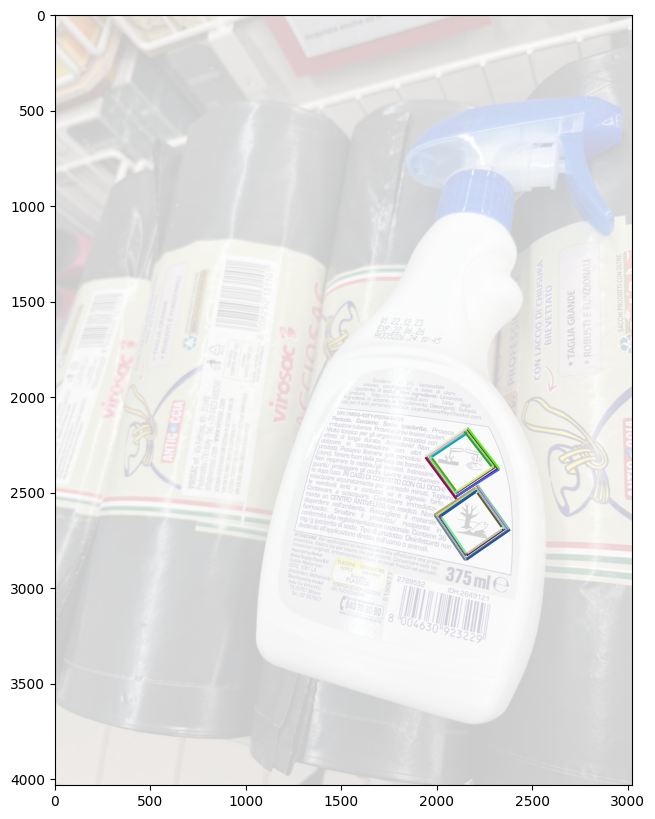

12:32:00 - SymbolDetectionPipeline - INFO - [info] - Found 48 segments


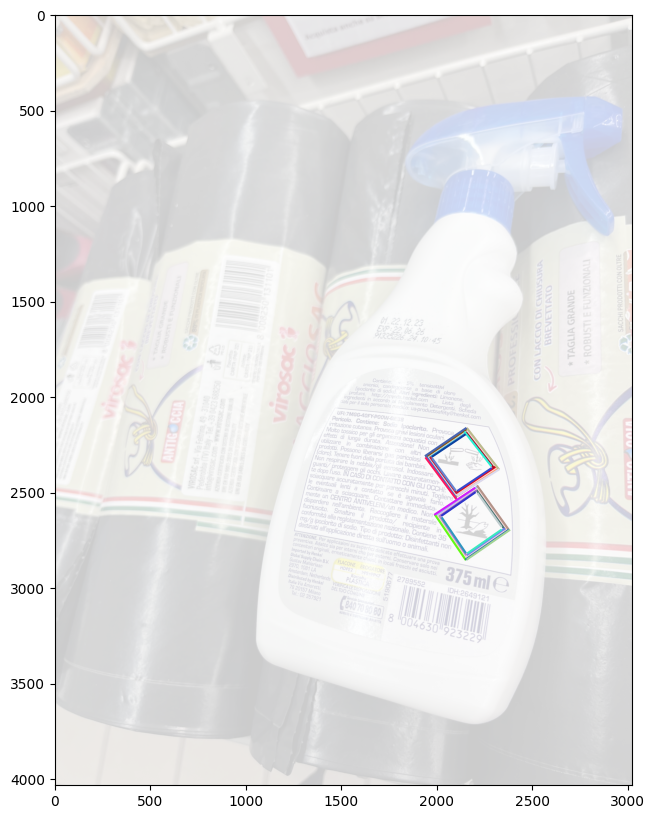

12:32:02 - SymbolDetectionPipeline - INFO - [info] - Found 29 segments after merging collinear segments
12:32:02 - SymbolDetectionPipeline - INFO - [timer] - ▶ Starting: 4-line cycle detection
12:32:02 - SymbolDetectionPipeline - INFO - [info] - Searching for 4-line cycles in 29 segments
12:32:02 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Adjacency radius computation
12:32:02 - SymbolDetectionPipeline - DEBUG - [debug] - Using provided adjacency radius: 5
12:32:02 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: Adjacency radius computation (1.0ms)
12:32:02 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: KDTree construction
12:32:02 - SymbolDetectionPipeline - DEBUG - [debug] - Built KDTree for 58 points
12:32:02 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: KDTree construction (2.6ms)
12:32:02 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Adjacency graph construction
12:32:02 - SymbolDetectionPipeline - DEBUG - [debug] -

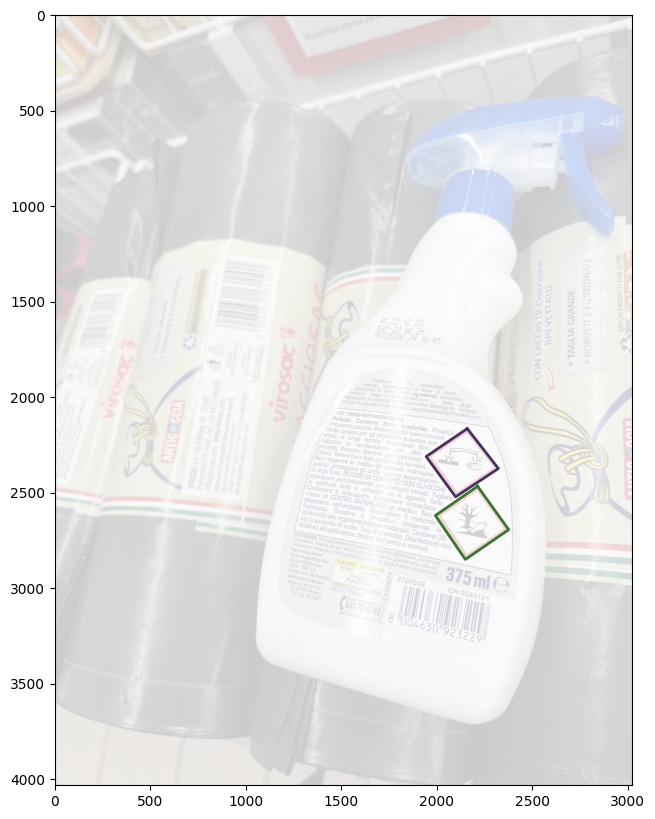

In [79]:
# Plot the quadrilaterals found in a particular mask over the original image
# Use the _masks array to get the mask for the quadrilateral

_mask_id = 0
_mask_chosen = _masks[_mask_id].copy()

_segments = get_segments(_mask_chosen, min_line_length_percent=0.05)

# debug: plot segments
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(_image, cmap='gray', alpha=0.2)
for seg in _segments:
	ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], color=np.random.rand(3))
plt.show()


logger.info(f"Found {len(_segments)} segments")
_segments = merge_collinear_segments(_segments)

# debug: plot segments
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(_image, cmap='gray', alpha=0.2)
for seg in _segments:
	ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], color=np.random.rand(3))
plt.show()

logger.info(f"Found {len(_segments)} segments after merging collinear segments")

# Find ordered loops of 4 lines
_loops = find_loops(_segments, adjacency_radius=5)
logger.info(f"Found {len(_loops)} loops")

# Get quadrilaterals from the loops
_quads = get_quadrilaterals_from_loops(_loops, _segments)

# debug: plot quads over image. 

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(_image, cmap='gray', alpha=0.2)
for quad in _quads:
    quad_np = np.array(quad)
    quad_closed = np.vstack([quad_np, quad_np[0]])
    ax.plot(quad_closed[:, 0], quad_closed[:, 1], color=np.random.rand(3), linewidth=2)
plt.show()



## Step 4-5: Template Matching and Verification

Final verification using homography estimation and photometric check with Normalized Cross-Correlation (NCC).


In [68]:
def check_template_match(candidate_rect, template_info, image, ncc_threshold=0.7):
    """
    Check if a candidate rectangle matches a template using homography and photometric verification.
    """
    template_name = os.path.basename(template_info['path'])
    
    with logger.timer(f"Template matching: {template_name}"):
        # try:
          # Get quadrilateral vertices
          with logger.timer("Vertex extraction", log_level=logging.DEBUG):
              quad_vertices = candidate_rect['vertices'].astype(np.float32)
              template_corners = template_info['corners']
              logger.debug(f"Template: {template_info['shape']}, Candidate colors: {candidate_rect['colors']}")
          
          
          # Find homography
          with logger.timer("Homography estimation", log_level=logging.DEBUG):
              H, mask = cv2.findHomography(
                  template_corners, 
                  quad_vertices, 
                  method=cv2.RANSAC, 
                  ransacReprojThreshold=2.0
              )
              
              if H is None:
                  logger.debug(f"Failed homography estimation for {template_name}")
                  return None
              
              inliers = np.sum(mask) if mask is not None else 0
              logger.debug(f"Homography found with {inliers}/4 inliers")
          
          # Warp template to match candidate
          with logger.timer("Template warping", log_level=logging.DEBUG):
              template_warped = cv2.warpPerspective(
                  template_info['image'], 
                  H, 
                  (image.shape[1], image.shape[0])
              )
          
          # Extract region of interest
          with logger.timer("ROI extraction", log_level=logging.DEBUG):
              mask_roi = np.zeros(image.shape[:2], dtype=np.uint8)
              cv2.fillPoly(mask_roi, [quad_vertices.astype(np.int32)], (255,))
              
              # Get bounding box for efficiency
              x, y, w, h = cv2.boundingRect(quad_vertices.astype(np.int32))
              logger.debug(f"ROI bounding box: ({x}, {y}, {w}, {h})")
              
              # Extract patches
              image_patch = image[y:y+h, x:x+w]
              template_patch = template_warped[y:y+h, x:x+w]
              mask_patch = mask_roi[y:y+h, x:x+w]
          
          # Photometric verification
          with logger.timer("Photometric verification", log_level=logging.DEBUG):
              # Convert to grayscale for NCC
              if len(image_patch.shape) == 3:
                  image_patch_gray = cv2.cvtColor(image_patch, cv2.COLOR_BGR2GRAY)
              else:
                  image_patch_gray = image_patch
                  
              if len(template_patch.shape) == 3:
                  template_patch_gray = cv2.cvtColor(template_patch, cv2.COLOR_BGR2GRAY)
              else:
                  template_patch_gray = template_patch
              
              # Apply mask
              image_patch_gray = cv2.bitwise_and(image_patch_gray, mask_patch)
              template_patch_gray = cv2.bitwise_and(template_patch_gray, mask_patch)
              
              # Normalized Cross-Correlation
              if image_patch_gray.shape != template_patch_gray.shape:
                  logger.debug(f"Shape mismatch: image {image_patch_gray.shape} vs template {template_patch_gray.shape}")
                  return None
                  
              ncc_result = cv2.matchTemplate(image_patch_gray, template_patch_gray, cv2.TM_CCOEFF_NORMED)
              ncc_score = np.max(ncc_result) if ncc_result.size > 0 else 0
              logger.debug(f"NCC score: {ncc_score:.3f} (threshold: {ncc_threshold})")
          
          if ncc_score > ncc_threshold:
              logger.info(f"✓ Template match found: {template_name} (NCC: {ncc_score:.3f})")
              return {
                  'vertices': quad_vertices,
                  'colors': candidate_rect['colors'],
                  'ncc_score': ncc_score,
                  'homography': H,
                  'bounding_box': (x, y, w, h),
                  'template_path': template_info['path']
              }
          else:
              logger.debug(f"NCC score {ncc_score:.3f} below threshold {ncc_threshold}")
        
        # except Exception as e:
        #     logger.error(f"Error in template matching for {template_name}: {e}")
        #     return None
    
    return None

def deduplicate_quadrilaterals_by_colors(quads, dedup_thresh=50):
    """
    Deduplicate quadrilaterals (dicts with 'vertices' and 'colors') by merging color lists
    for near-identical quads (within dedup_thresh vertex distance).
    Args:
        quads: list of dicts {'vertices': quad_pts, 'colors': [color_indices]}
        dedup_thresh: float, threshold for considering two quads identical
    Returns:
        List of dicts {'vertices': quad_pts, 'colors': [color_indices]} with merged colors
    """
    deduped = []
    for i, quad in enumerate(quads):
        quad_pts = quad['vertices']
        quad_colors = set(quad['colors'])
        found_duplicate = False
        for j, existing in enumerate(deduped):
            dist = quad_distance(quad_pts, existing['vertices'])
            if dist < dedup_thresh:
                existing['colors'] = sorted(set(existing['colors']).union(quad_colors))
                found_duplicate = True
                break
        if not found_duplicate:
            deduped.append({'vertices': quad_pts, 'colors': sorted(list(quad_colors))})
    return deduped



## Complete Pipeline Integration


In [86]:
def symbol_detection_pipeline(image_path, template_paths, reference_colors, clusters, ncc_threshold=0.7, min_line_length_percent=0.05, adjacency_radius=5, debug=False):
    """
    Complete pipeline for symbol detection using color + line-based approach.
    
    Args:
        image_path: Path to input image
        template_paths: List of paths to template images
        reference_colors: Array of reference RGB colors
        clusters: Dictionary of clusters of reference colors
        ncc_threshold: NCC threshold for template matching
        min_line_length_percent: Minimum length of a line segment as a percentage of the image width
        adjacency_radius: Radius for finding adjacent lines
        debug: If True, return debug information
    
    Returns:
        List of detected matches with their information
    """
    with logger.timer("SYMBOL DETECTION PIPELINE"):
        logger.info("=" * 60)
        logger.info("Starting Symbol Detection Pipeline")
        logger.info("=" * 60)
        
        # Pipeline configuration logging
        logger.info(f"Input image: {os.path.basename(image_path)}")
        logger.info(f"Templates: {len(template_paths)} files")
        logger.info(f"Reference colors: {len(reference_colors)} colors")
        logger.info(f"Debug mode: {debug}")
        
        # Step 0: Load input image
        with logger.timer("Image loading"):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if image is None:
                raise ValueError(f"Could not load image: {image_path}")
            logger.info(f"Loaded image: {image.shape} ({image.shape[0]*image.shape[1]:,} pixels)")
        
        # Step 0b: Load templates
        with logger.timer("Template loading"):
            templates = []
            for i, template_path in enumerate(template_paths):
                with logger.timer(f"Loading template {i+1}/{len(template_paths)}", log_level=logging.DEBUG):
                    template_info = load_template_info(template_path, clusters)
                    templates.append(template_info)
                    logger.debug(f"Template {i+1}: {os.path.basename(template_path)} ({template_info['shape']})")
            logger.info(f"Loaded {len(templates)} templates successfully")

        # Step 1-2: Color splitting using RGB
        logger.info("-" * 40)
        logger.info("STEP 1-2: Color Mask Generation")
        color_masks = get_rgb_masks(image, reference_colors)
        
        # Step 3-4: Line detection and rectangle finding
        logger.info("-" * 40)
        logger.info("STEP 3-4: Line Detection & Rectangle Matching")

        all_quads = []
        for idx_mask, mask in enumerate(color_masks):
            segments = get_segments(mask, min_line_length_percent)
            segments = merge_collinear_segments(segments)
            loops = find_loops(segments, adjacency_radius)
            quads = [
                {
                'vertices': np.array(q),
                'colors': [idx_mask],
                }
                for q in get_quadrilaterals_from_loops(loops, segments)
              ]
            all_quads.extend(quads)
        logger.info(f"Pipeline intermediate result: {len(all_quads)} candidate rectangles")
        all_quads = deduplicate_quadrilaterals_by_colors(all_quads, dedup_thresh=100)
        logger.info(f"Candidate rectangles after deduplication: {len(all_quads)}")


        if debug:
            import matplotlib.pyplot as plt
            from matplotlib.patches import Polygon

            fig, axs = plt.subplots(1, len(all_quads), figsize=(4 * len(all_quads), 4))
            if len(all_quads) == 1:
                axs = [axs]
            for idx, quad in enumerate(all_quads):
                vertices = quad['vertices']
                # Compute bounding box
                min_x = int(np.floor(np.min(vertices[:, 0])))
                max_x = int(np.ceil(np.max(vertices[:, 0])))
                min_y = int(np.floor(np.min(vertices[:, 1])))
                max_y = int(np.ceil(np.max(vertices[:, 1])))

                # Clip to image bounds
                min_x = max(min_x, 0)
                min_y = max(min_y, 0)
                max_x = min(max_x, image.shape[1] - 1)
                max_y = min(max_y, image.shape[0] - 1)

                # Crop the region
                crop = image[min_y:max_y+1, min_x:max_x+1].copy()

                # Shift vertices to crop coordinates
                shifted_vertices = vertices - np.array([min_x, min_y])

                axs[idx].imshow(crop)
                poly = Polygon(shifted_vertices, closed=True, fill=False, edgecolor='red', linewidth=2)
                axs[idx].add_patch(poly)
                axs[idx].set_title(f"Candidate {idx+1}")
                axs[idx].axis('off')
            plt.tight_layout()
            plt.show()
        
        
        # Step 5: Template matching and verification
        logger.info("-" * 40)
        logger.info("STEP 5: Template Matching & Verification")
        with logger.timer("Template matching for all candidates"):
            final_matches = []
            template_attempts = 0
            successful_matches = 0
            
            for candidate_idx, candidate in enumerate(all_quads):
                logger.debug(f"Processing candidate {candidate_idx+1}/{len(all_quads)}")
                
                for template_idx, template_info in enumerate(templates):
                    template_attempts += 1
                    template_name = os.path.basename(template_info['path'])

                    # Check if all candidate colors are present in the template's color list
                    if not all(color in template_info['colors'] for color in candidate['colors']):
                        logger.info(f"Candidate {candidate_idx} colors ({candidate['colors']}) are not found in template {template_name} ({template_info['colors']}). Skipping...")
                        continue
                    
                    with logger.timer(f"Candidate {candidate_idx} vs {template_name}", log_level=logging.DEBUG):
                        match_result = check_template_match(
                            candidate, template_info, image, ncc_threshold
                        )
                        
                        if match_result:
                            match_result['template_info'] = template_info
                            match_result['candidate_idx'] = candidate_idx
                            match_result['template_idx'] = template_idx
                            final_matches.append(match_result)
                            successful_matches += 1
                            logger.info(f"Match #{successful_matches}: Candidate {candidate_idx} ↔ {template_name}")
            
            logger.info(f"Template matching complete: {successful_matches}/{template_attempts} attempts successful")
        
        # Prepare results
        with logger.timer("Result compilation"):
            results = {
                'matches': final_matches,
                'num_candidates': len(all_quads),
                'num_templates': len(templates),
                'template_attempts': template_attempts,
                'image_shape': image.shape,
                'pipeline_config': {
                    'ncc_threshold': ncc_threshold,
                    'reference_colors': reference_colors
                }
            }
            
            if debug:
                results['debug'] = {
                    'color_masks': color_masks,
                    'all_quads': all_quads,
                    'templates': templates
                }
        
        # Final summary
        logger.info("=" * 60)
        logger.info("PIPELINE SUMMARY")
        logger.info("=" * 60)
        logger.info(f"✓ Input: {os.path.basename(image_path)} ({image.shape[0]}x{image.shape[1]})")
        logger.info(f"✓ Templates processed: {len(templates)}")
        logger.info(f"✓ Color masks generated: {len(color_masks)}")
        logger.info(f"✓ Candidate rectangles: {len(all_quads)}")
        logger.info(f"✓ Template matching attempts: {template_attempts}")
        logger.info(f"✓ FINAL MATCHES FOUND: {len(final_matches)}")
        
        if final_matches:
            logger.info("Final matches:")
            for i, match in enumerate(final_matches):
                template_name = os.path.basename(match['template_path'])
                logger.info(f"  Match {i+1}: {template_name} (NCC: {match['ncc_score']:.3f}, Colors: {match['colors']})")
        
        logger.info("=" * 60)
        
        return results

def visualize_results(image_path, results, output_path=None):
    """
    Visualize detection results on the original image.
    """
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image_rgb)
    
    # Draw detected matches
    for i, match in enumerate(results['matches']):
        vertices = match['vertices']
        ncc_score = match['ncc_score']
        
        # Draw quadrilateral
        polygon = Polygon(vertices, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(polygon)
        
        # Add label
        center_x = np.mean(vertices[:, 0])
        center_y = np.mean(vertices[:, 1]) - 10 # offset to avoid overlap with quadrilateral
        ax.text(center_x, center_y, f'Match {i+1} \n NCC: {ncc_score:.3f}', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                ha='center', va='center', fontsize=8)
    
    ax.set_title(f'Symbol Detection Results - {len(results["matches"])} matches found')
    ax.axis('off')
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        print(f"Visualization saved to: {output_path}")
    
    plt.show()
    
    return fig


## Testing and Dry Run


In [87]:
# Example usage and testing
def run_test_pipeline(prefix=None):
    """
    Test the complete pipeline with sample images from your dataset
    """
    with logger.timer("TEST PIPELINE EXECUTION"):
        logger.info("🚀 Starting test pipeline execution")
        logger.info(f"Template prefix filter: {prefix}")
        
        # Setup paths
        with logger.timer("Test setup"):
            base_path = "../template_matching/dataset"
            images_path = os.path.join(base_path, "images/positive")
            templates_path = os.path.join(base_path, "templates")

            # Get test images
            image_paths = []
            for file in sorted(os.listdir(images_path)):
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_paths.append(os.path.join(images_path, file))
            
            # Get template files
            template_paths = []
            for file in sorted(os.listdir(templates_path)):
                if file.endswith(".png") and (prefix is None or prefix in file):
                    template_paths.append(os.path.join(templates_path, file))
            
            logger.info(f"Found {len(image_paths)} test images")
            logger.info(f"Found {len(template_paths)} template files")
            
            if not image_paths:
                logger.error("No test images found!")
                return None
            
            if not template_paths:
                logger.error("No template files found!")
                return None
        
        # Extract reference colors
        reference_colors, clusters = get_template_colors(templates_path, filename_prefix=prefix)
        
        if not reference_colors:
            logger.error("No reference colors extracted!")
            return None

        # Select test image
        test_image = image_paths[0]
        logger.info(f"Selected test image: {os.path.basename(test_image)}")
        
        try:
            # Run the main pipeline
            results = symbol_detection_pipeline(
                image_path=test_image,
                template_paths=template_paths,
                reference_colors=reference_colors,
                clusters=clusters,
                debug=True
            )
            
            # Log detailed results
            logger.info("📊 DETAILED TEST RESULTS")
            logger.info("-" * 40)
            logger.info(f"Total matches found: {len(results['matches'])}")
            logger.info(f"Candidate rectangles processed: {results['num_candidates']}")
            logger.info(f"Template attempts: {results['template_attempts']}")
            logger.info(f"Success rate: {len(results['matches'])/results['template_attempts']*100:.1f}%" if results['template_attempts'] > 0 else "Success rate: N/A")
            
            if results['matches']:
                logger.info("\n📋 Match Details:")
                for i, match in enumerate(results['matches']):
                    template_name = os.path.basename(match['template_path'])
                    logger.info(f"  Match {i+1}: {template_name}")
                    logger.info(f"    - NCC Score: {match['ncc_score']:.3f}")
                    logger.info(f"    - Colors: {match['colors']}")
                    logger.info(f"    - Bounding Box: {match['bounding_box']}")
                    logger.info(f"    - Area: {cv2.contourArea(match['vertices']):.1f} pixels")
            else:
                logger.warning("No matches found in test run")
            
            # Attempt visualization
            try:
                with logger.timer("Result visualization"):
                    visualize_results(test_image, results)
                    logger.info("✓ Visualization completed successfully")
            except Exception as e:
                logger.error(f"Visualization failed: {e}")
            
            logger.info("✅ Test pipeline completed successfully")
            return results
            
        except Exception as e:
            logger.error(f"❌ Pipeline failed with error: {e}")
            import traceback
            logger.error(f"Traceback: {traceback.format_exc()}")
            return None


12:36:34 - SymbolDetectionPipeline - INFO - [timer] - ▶ Starting: TEST PIPELINE EXECUTION
12:36:34 - SymbolDetectionPipeline - INFO - [info] - 🚀 Starting test pipeline execution
12:36:34 - SymbolDetectionPipeline - INFO - [info] - Template prefix filter: GHS
12:36:34 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Test setup
12:36:34 - SymbolDetectionPipeline - INFO - [info] - Found 20 test images
12:36:34 - SymbolDetectionPipeline - INFO - [info] - Found 24 template files
12:36:34 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: Test setup (8.6ms)
12:36:34 - SymbolDetectionPipeline - INFO - [timer] -   ▶ Starting: Template color extraction from ../template_matching/dataset/templates
12:36:34 - SymbolDetectionPipeline - INFO - [info] - Extracting colors from templates with prefix: GHS, min_percentage: 0.1
12:36:34 - SymbolDetectionPipeline - INFO - [timer] -     ▶ Starting: Directory scanning
12:36:34 - SymbolDetectionPipeline - INFO - [info] - Found 24 PNG files 

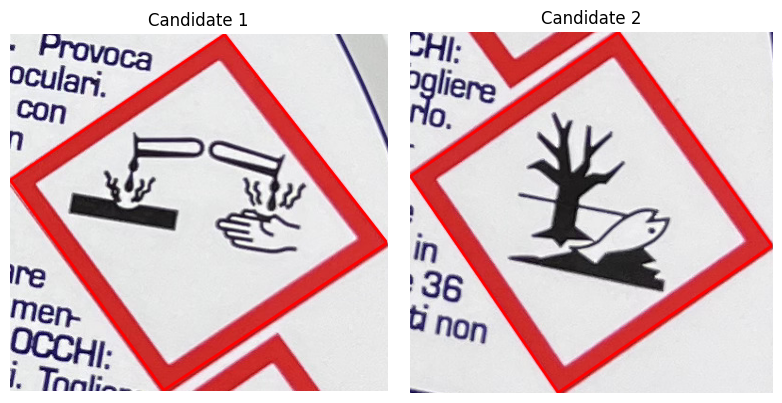

12:36:58 - SymbolDetectionPipeline - INFO - [info] - ----------------------------------------
12:36:58 - SymbolDetectionPipeline - INFO - [info] - STEP 5: Template Matching & Verification
12:36:58 - SymbolDetectionPipeline - INFO - [timer] -     ▶ Starting: Template matching for all candidates
12:36:58 - SymbolDetectionPipeline - DEBUG - [debug] - Processing candidate 1/2
12:36:58 - SymbolDetectionPipeline - DEBUG - [timer] -       ▶ Starting: Candidate 0 vs GHS_00000.png
12:36:58 - SymbolDetectionPipeline - INFO - [timer] -         ▶ Starting: Template matching: GHS_00000.png
12:36:58 - SymbolDetectionPipeline - DEBUG - [timer] -           ▶ Starting: Vertex extraction
12:36:58 - SymbolDetectionPipeline - DEBUG - [debug] - Template: (150, 150), Candidate colors: [0, 5]
12:36:58 - SymbolDetectionPipeline - DEBUG - [timer] -           ✓ Completed: Vertex extraction (1.1ms)
12:36:58 - SymbolDetectionPipeline - DEBUG - [timer] -           ▶ Starting: Homography estimation
12:36:58 - Symbo

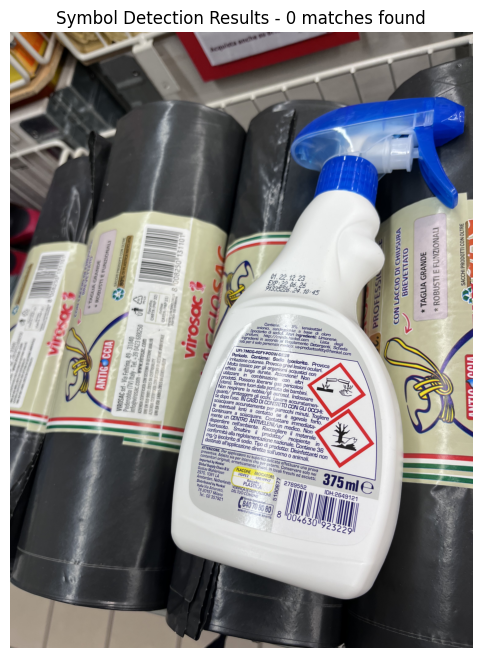

12:37:01 - SymbolDetectionPipeline - INFO - [info] - ✓ Visualization completed successfully
12:37:01 - SymbolDetectionPipeline - INFO - [timer] -   ✓ Completed: Result visualization (1.02s)
12:37:01 - SymbolDetectionPipeline - INFO - [info] - ✅ Test pipeline completed successfully
12:37:01 - SymbolDetectionPipeline - INFO - [timer] - ✓ Completed: TEST PIPELINE EXECUTION (27.18s)


{'matches': [],
 'num_candidates': 2,
 'num_templates': 24,
 'template_attempts': 48,
 'image_shape': (4032, 3024, 3),
 'pipeline_config': {'ncc_threshold': 0.7,
  'reference_colors': [array([235.75,  55.5 ,  26.5 ]),
   array([  0., 147., 221.]),
   array([245., 240.,  20.]),
   array([ 75., 176.,  51.])]},
 'debug': {'color_masks': [array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 

In [88]:
run_test_pipeline(prefix='GHS')